<a href="https://colab.research.google.com/github/rubtobar/filtros-morfologicos/blob/main/filtros_morfologicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eliminación de ruido impulsivo en imagenes binarias de huellas dactilares

El objetivo de este estudio es el de utilizar filtros morfologicos para la eliminación de ruido impulsivo en una imagen de una huella dactilar. Para llevar a cabo esta tarea debemos preservar las caracteristicas de la imagen para evitar modificar la huella digitalizada. Utilizaremos los filtros de apertura y cierre combinados para eliminar el ruido en las zonas del background y del foreground en la imagen.

Todas las implementaciones utilizadas son propias. Se ha hecho uso de las reglas del inverso para generar el resto de operaciones sin tener que realizar varias implementaciones desde cero.



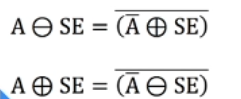

El uso de estas reglas nos ha permitido generar la operación de la erosión reutilizando la operación de dilatación implementada.

A continuación se muestra el desarrollo de los algoritmos de dilatación y erosión que nos servirán como base para el desarrollo de los algoritmos de apertura y cierre.
A su vez, estos dos ultimos serán utilizados en combinación para eliminar el ruido impulsivo de la imagen.

## Algoritmos de dilatación y erosión

A continuación cargamos las librerías y la imagen de la huella dactilar que utilizaremos en nuestro estudio.

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Imagene extraida de https://unipython.com/transformaciones-morfologicas/
img = cv2.imread('fingerprint.png',0)

En primer lugar binarizamos los valores de la imagen, poniendo el foreground a 1 y el background a 0. 

In [4]:
# Binarizamos la imagen, esta solo puede tomar los valores 0 o 255
threshold = 128
img_binary = 1 * (img > threshold)
np.unique(img_binary) # Muestra los diferentes valores que encontramos dentro del array

array([0, 1])

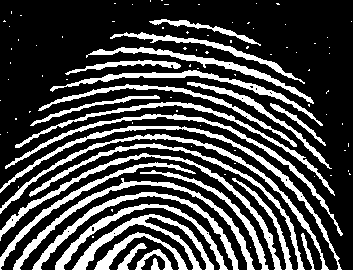

In [5]:
cv2_imshow(img_binary*255)

### Dilatación
El algoritmo de dilatación utiliza un kernel de 3x3 con el punto de anclaje en el centro. En el caso de los bordes de la imagen hemos utilizado la estrategia de padding. Esta consiste en añadir un borde de pixeles a 0 alrededor de la imagen. Esto permite que al pasar el kernel, la operación nunca salga de los pixeles de la imagen, pudiendo así computar los bordes originales con el kernel.

Esta operación nos permite eliminar el ruido del background, pero nos agranda la superficie del foreground, haciendo las lineas de la huella más gruesas.

In [6]:
# Dilatación
def dilatacion(img):
  height = img.shape[0]
  width  = img.shape[1]

  # Utilizando el padding de ceros alrededor de nuestra imagen de entrada evitamos los errores de computar fuera de los bordes

  '''
  Las X son el padding añadido y las I la imagen.

    X X X X X X X X
    X I I I I I I X
    X I I I I I I X
    X I I I I I I X
    X I I I I I I X
    X X X X X X X X

  '''
  def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

  frame = np.pad(img, 1, pad_with)
  result = np.zeros((height,width), dtype=int)

  
  for h in range(1,height+1):
    for w in range(1,width+1):
      # Si no es el borde comprobamos los valores
      '''
      Nuestro Kernel tiene esta forma
      [1  1  1]
      [1 [1] 1]
      [1  1  1]
      Siendo el centro el punto de anclaje

      La siguiente operación representa ese paso del kernel
      '''

      value = (
          frame[h-1][w-1] + frame[h-1][w+0] + frame[h-1][w+1]
        + frame[h+0][w-1] + frame[h+0][w+0] + frame[h+0][w+1]
        + frame[h+1][w-1] + frame[h+1][w+0] + frame[h+1][w+1] )

      if (value > 0):
        result[h-1][w-1] = 1

  return result

In [7]:
dilat = dilatacion(img_binary)

Mostramos la imagen original después de realizarle la operación de dilatación. Vemos como el foreground (la parte blanca), se ha hecho más gruesa. El rudio ha ganado tamaño también.

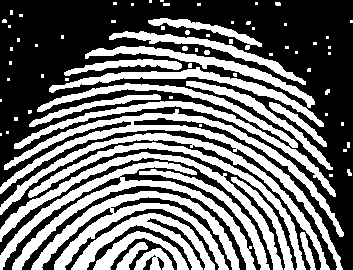

In [8]:
cv2_imshow(dilat*255)

### Erosión
Para la erosión en vez de realizar una implementación desde cero hacemos uso de las reglas de las operaciónes duales. Así pues únicamente necesitaremos la dilatación y el opuesto de la imagen (ceros a uno y unos a 0) para poder hacer una erosión.



In [9]:
# Erosion: teniendo en cuenta que --> A eros SE = ¬(¬A dilat SE) podemos usar la dilatación para generar la erosión
def erosion(img):
  '''
  conseguimos ¬A cambiando 0 por 1 y 1 por 0
  Para ello usamos la puerta XOR, he encontrado
  la idea aqui https://stackoverflow.com/questions/56594598/change-1s-to-0-and-0s-to-1-in-numpy-array-without-looping/56594688
  '''
  not_A =  np.where((img==0)|(img==1), img^1, img)
  dilat = dilatacion(not_A)
  not_dilatacion = np.where((dilat==0)|(dilat==1), dilat^1, dilat)

  return not_dilatacion

In [10]:
eros = erosion(img_binary)

Mostramos la operación de erosión sobre la imagen. Vemos como el background ha ganado espacio. El ruido de fuera de la huella se ha eliminado.

Por otra parte hemos perdido superficie de foreground, eliminando mucha información de la huella dactilar.

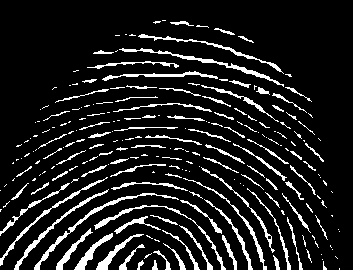

In [11]:
cv2_imshow(eros*255)

## Algoritmos de apertura y cierre
Estos algoritmos estan desaroyados a partir de las implementaciones anteriores.

Este algoritmo tiene la ventaja de que elimina el ruido del background, pero realiza operaciones en la imagen que no la dejan exactamente como estaba.
Asi mismo, hace un buen trabajo recuperando la forma original.

### Apertura
Para la apertura relizamos una erosión seguida de una dilatación.

In [12]:
# Apertura --> A aperture SE = (A eros SE) dilat SE
def apertura(img):
  eros_A = erosion(img)
  dilat = dilatacion(eros_A)

  return dilat

In [13]:
apert = apertura(img_binary)

Mostramos la imagen después de la apertura y vemos como el ruido del background se ha eliminado.

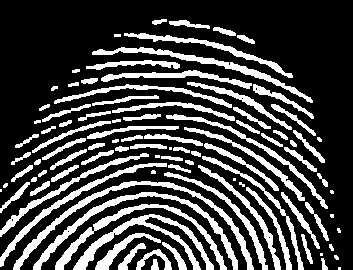

In [14]:
cv2_imshow(apert*255)

### Cierre
Para el algoritmo de cierre hacemos una dilatación seguida de una erosión.

Este algoritmo tiene la ventaja de que elimina el ruido del foreground, pero realiza operaciones en la imagen que no la dejan exactamente como estaba.
Asi mismo, hace un buen trabajo recuperando la forma original.

In [15]:
# Cierre --> A cierr SE = (A dilat SE) eros SE
def cierre(img):
  dilat_A = dilatacion(img)
  eros = erosion(dilat_A)
  return eros
  

In [16]:
cierr = cierre(img_binary)

A continuación se muestra la ejecución del algorimto de cierre sobre la imagen de la huella dactilar. Vemos como esta operación tiene como objetivo eliminar el ruido del foreground. En nuestro caso esto no es un problema ya que dentro de la huella no se aprecia tanto ruido.

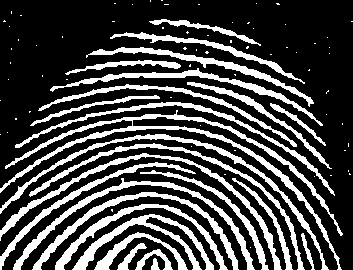

In [17]:
cv2_imshow(cierr*255)

## Eliminación del ruido impulsivo
Una vez tenemos definidas todas la soperaciones anteriores podemos proceder a generar la función de eliminación del ruido impulsivo. Esta función ejecuta una apertura seguida de una cierre.

Una vez ejecutada esta operación, tanto background como foreground vuelven a un estado más cercano al original pero habiendo eliminado el ruido impulsivo en toda la imagen.

Esata operación tiene la ventaja de que elimina el ruido impulsivo en toda la imagen, pero tiene como desventaja que las formas no vuelven a su estado original exacto una vez eliminado el ruido.
Aún así, se recupera en gran medida la forma original de la imagen.

In [18]:
# Ahora hacemos la eliminación del ruido impulsivo tanto del background como del foreground

# (A apertura SE) cierre SE

# Elim ruido impulsivo
def elim_ruido_impulsivo(img):
  apert = apertura(img)
  return cierre(apert)

In [19]:
no_ruido = elim_ruido_impulsivo(img_binary)

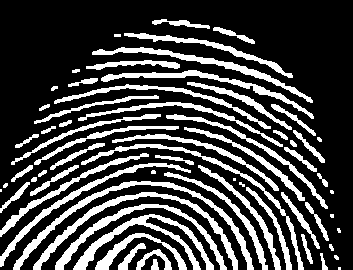

In [20]:
cv2_imshow(no_ruido*255)